## Diabetes predictor

### Introduction

Diabetes is a health issue that concerns many people in the world. It is a disease which causes the pancreas to reduce or stop the secretion of insulin. This causes glucose to stay in the blood. According to the CDC, this can cause problems like vision loss, heart disease and kidney disease in the long run (What Is Diabetes?, 2023). It is safe to say Diabetes causes many problems and should be researched more. 

In this project, we will be predicting whether a patient has diabetes or not based on Insulin levels, Blood Sugar levels, BMI and DiabetesPedigreeFunction which is basically the person's familial history of diabetes (whether the person's parents or grandparents have Diabetes). 

Predictive question: Using the variables mentioned above, can we determine if particular patient has diabetes or not?

We will be using the dataset originally from the National Institute of Diabetes and Digestive and Kidney Diseases. All patients are females (at least 21 years old) of Pima Indian heritage. It has 9 columns : Pregnancies (number of pregnancies a person has had), Glucose (glucose levels in blood),  BloodPressure, SkinThickness, Insulin, BMI (Body Mass Index), DiabetesPedigreeFunction (if the person has a family history of diabetes), Age and Outcome. 

Outcomes is a categorical variable which has 2 values: 1 if the patient is diabetic and 0 if the patient is not diabetic.


### Preliminary exploratory data analysis

In [25]:
library(tidyverse)
diabetes <- read_csv("diabetes.csv")
diabetes |> slice(1:10)
diabetes <- diabetes |> mutate(Outcome = as_factor(Outcome))
diabetes |> slice(1:10)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


Now let us do some exploratory analysis: Let us split the data into training data - 75% of the dataset and testing data - 25% of the dataset.
Then we will see the percentage of patients who have diabetes in the training data

In [26]:
library(tidymodels)

set.seed(1)

diabetes_split <- initial_split(diabetes, prop = 0.75, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

total_patients <- nrow(diabetes_train)
total_patients
diabetes_train |> group_by(Outcome) |> summarize(count = n()) |> mutate(percentage = count / total_patients * 100)

[1] 576

Outcome,count,percentage
<fct>,<int>,<dbl>
0,375,65.10417
1,201,34.89583


This shows that about 35% of the patients here have diabetes.

Now let us look at the predictors for our predictive search, starting with BMI. BMI lower than 9 is linked to high rates of mortality so we will filter out these rows (Frolich et al., 2016).

In [27]:
diabetes_train <- diabetes_train |> filter(BMI >= 9)
nrow(diabetes_train)

[1] 567

Let us continue this process with the other predictors. We will be using Insulin, DiabetesPedigreeFunction, Glucose and BMI to determine if a patient has diabetes. We should also check if there is any missing data in the dataset which can be done simultaneously during this process. Let us first convert the columns to numeric types.

In [28]:
diabetes_train <- diabetes_train |> mutate(Insulin = as.numeric(Insulin), DiabetesPedigreeFunction = as.numeric(DiabetesPedigreeFunction), 
                               Glucose = as.numeric(Glucose))

Let us check how many rows have missing data in Insulin

In [29]:
insulin_missing_data <- diabetes_train |> filter(is.na(Insulin)) |> nrow()
insulin_missing_data

[1] 0

That is good, we have no missing data, let us repeat this with DiabetesPedigreeFunction, and Glucose.

In [30]:
DiabetesPedigreeFunction_missing_data <- diabetes_train |> filter(is.na(DiabetesPedigreeFunction)) |> nrow()
DiabetesPedigreeFunction_missing_data

Glucose_missing_data <- diabetes_train |> filter(is.na(Glucose)) |> nrow()
Glucose_missing_data

[1] 0

[1] 0

Now we know that there is no missing data. Now let us group together the patients who have diabetes and those who do not and find the mean of Insulin levels, Glucose levels, DiabetesPedigreeFunction and BMI to analyze further.

In [31]:
diabetes_train |> group_by(Outcome) |> summarize(mean_Insulin = mean(Insulin), mean_Glucose = mean(Glucose),
                                        mean_DiabetesPedigreeFunction = mean(DiabetesPedigreeFunction),
                                        mean_BMI = mean(BMI))

Outcome,mean_Insulin,mean_Glucose,mean_DiabetesPedigreeFunction,mean_BMI
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,65.54891,110.5978,0.4191902,30.85245
1,110.40704,141.4774,0.5410653,35.43166


We can see that people who have Diabetes have higher average Insulin levels, higher average Glucose levels, a higher average DiabetesPedigreeFunction and a higher average BMI.

Let us now visualize the data. We will plot Insulin against Glucose, DiabetesPedigreeFunction and BMI since lack of production of insulin is the main cause of diabetes.

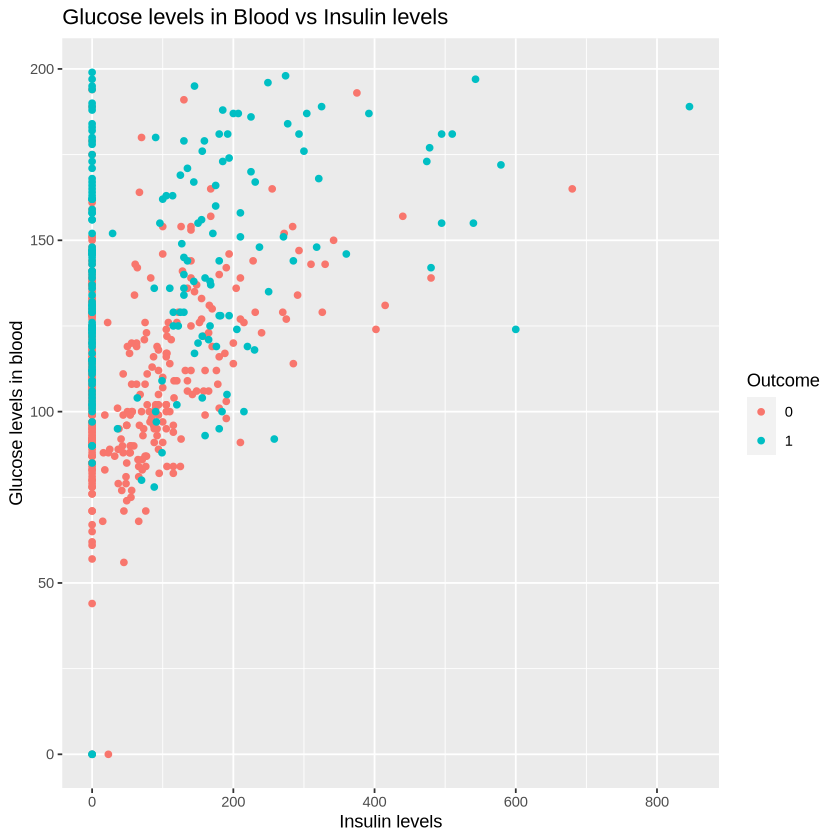

In [37]:
diabetes_train |> ggplot(aes(x = Insulin, y = Glucose, colour = Outcome)) + geom_point() + xlab("Insulin levels") + 
                ylab("Glucose levels in blood") + ggtitle("Glucose levels in Blood vs Insulin levels")

We can see that there' a weak positive relationship between Insulin and Glucose levels. We can say, as glucose levels in blood increases, there is a higher chance of the person having diabetes.

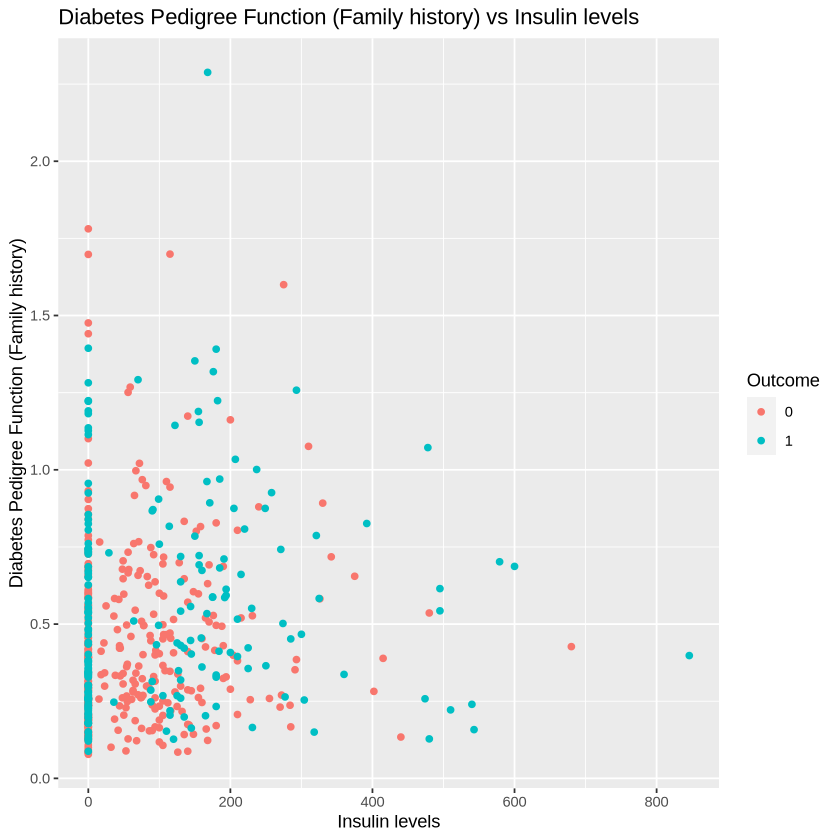

In [36]:
diabetes_train |> ggplot(aes(x = Insulin, y = DiabetesPedigreeFunction, colour = Outcome)) + geom_point() + xlab("Insulin levels") + 
                ylab("Diabetes Pedigree Function (Family history)") + 
                ggtitle("Diabetes Pedigree Function (Family history) vs Insulin levels")

There is no relaionship between DiabetesPedigree Function and Insulin. The points are too scattered. 

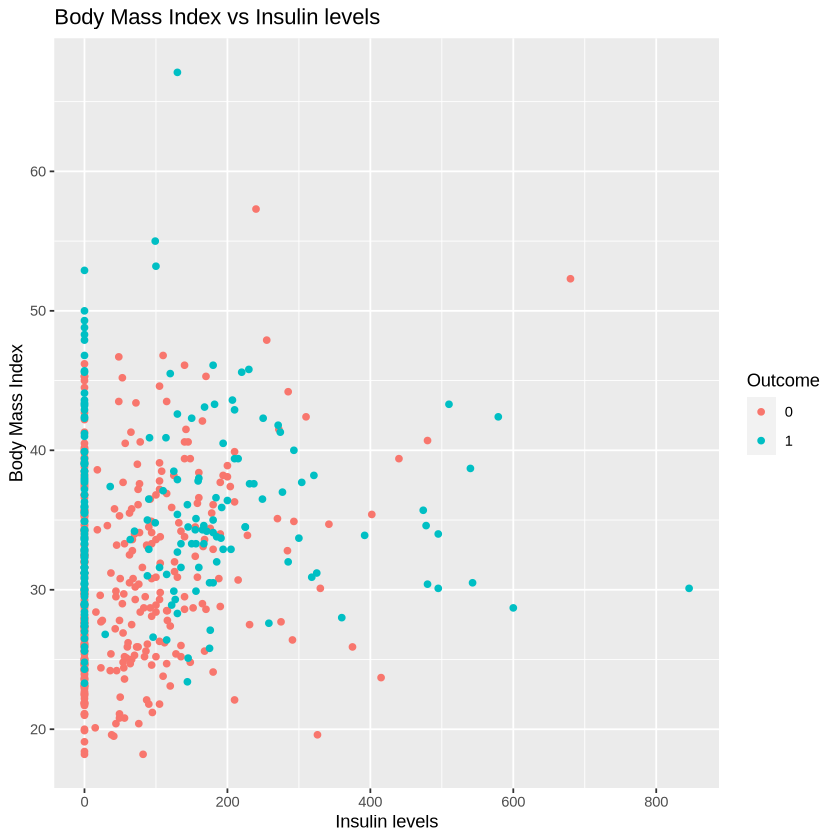

In [38]:
diabetes_train |> ggplot(aes(x = Insulin, y = BMI, colour = Outcome)) + geom_point() + xlab("Insulin levels") + 
                ylab("Body Mass Index") +
                ggtitle("Body Mass Index vs Insulin levels")

Weak positive relationship between Body Mass Index and Insulin. However, from the plot, we cannot say that higher BMI causes higher chances of diabetes as it is quite random.

### Methods

We will be using classification to predict the Outcome. For the diabetes predictive analysis, we think it is best to use the Insulin, Glucose, DiabatesPedigreeFunction and BMI columns as predictors for the predicting the Outcome. This is because, these are some of the major determining factors while diagnosing diabetes. We will train the diabetes_train dataset and test it on diabetes_test. This will help us determine how accurate and precise the prediction is. 

For visualizing the results, we will plot the the Glucose vs Insulin plot colouring according to the .pred_class and the Glucose vs Insulin plot colouring according to the actual Outcome next to each other to compare. 

### Expected Outcome and Significance

We made this data analysis (specifically predictive analysis - classification) to predict which patients have Diabetes based on BMI, DiabetesPedigreeFunction, Insulin levels and blood Glucose levels. 

It could be used in hospitals if they already have some information  about the patients (Insulin, Glucose, DiabatesPedigreeFunction and BMI) and they would not have to run diagnostics again, so it saves resources. 

We could further classify the patients into the type of diabetes they have, which can help diagnose them faster and provide proper medication and treatment as soon as possible.

### References:

    What is Diabetes? (2023, September 5). Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/diabetes.html
    
    Frølich, J., Palm, C. V., & Støving, R. K. (2016). To the limit of extreme malnutrition. Nutrition (Burbank, Los Angeles County, Calif.), 32(1), 146–148. https://doi.org/10.1016/j.nut.2015.08.024